# Vector Rayleigh-Sommerfeld method: Improvement in vacuum

En VRS_paper hemos desarrollado los algoritmos de Citation Huapeng Ye et al 2013 Laser Phys. Lett. 10 065004 https://iopscience.iop.org/article/10.1088/1612-2011/10/6/065004

Este artículo es estupendo, pues nos permite propagar el campo eléctrico de forma vectorial con un algoritmo muy rápido. 

**Problemas**:
- El campo de entrada es (Ex, Ey, 0), es decir no tiene componente longitudinal
- La función de propagación no es simétrica
- No se puede pasar de campo Ex a Ey (el cuadrupolo) ni de Ez a (Ex,Ey)

Por otro lado, viendo los resultados para tamaños tan pequeños, la calidad de propagación es muy alta incluso para distancias mínimas. Esto permitirá propagar como si fuera una algoritmo de $\Delta z$ en lugar de ser un algoritmo de salto.

**Propuesta**:
1. Simetrizar la ecuación de propagación de VRS
1. Propagar en el vacío mediante un algoritmo de salto ara ver si se puede obtener el cuadrupolo
1. Propagar a través de los materiales mediante un algortimos similar a WPM.

Empezaremos por la difracción por un agujero, con los mismos parámetros que la primera parte del paper VRS.

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from matplotlib import rcParams
rcParams['figure.dpi']=250
from matplotlib import cm

In [49]:
from diffractio import np, sp, plt, nm, um, mm, degrees

from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.vector_fields_XY import Vector_field_XY

import copy

## Radial polarized Gaussian beam through a circular aperture
In Figure 3, the propagation of a radially polarized Gaussian beam is performed. The diameter of teh circular aperture is D = 10$\lambda$, and the beam is FWHM = 6 $\mu$m.

In [50]:
size=6.4*um
x0=np.linspace(-size,size,512)
y0=np.linspace(-size,size,512)


In [51]:
wavelength=.640*um

radius=10*wavelength/2
z_obs=10*um
beam_width=6*um/(2*np.sqrt(2))

In [52]:
u0=Scalar_source_XY(x0,y0,wavelength)
u0.gauss_beam(A=1,r0=(0,0), z0=0, w0=beam_width)

t0=Scalar_mask_XY(x0,y0,wavelength)
t0.circle(r0=(0,0), radius=radius)

t=u0*t0

In [53]:
E0 = Vector_source_XY(x0,y0,wavelength)
E0.radial_wave(u=t,r0=(0,0))

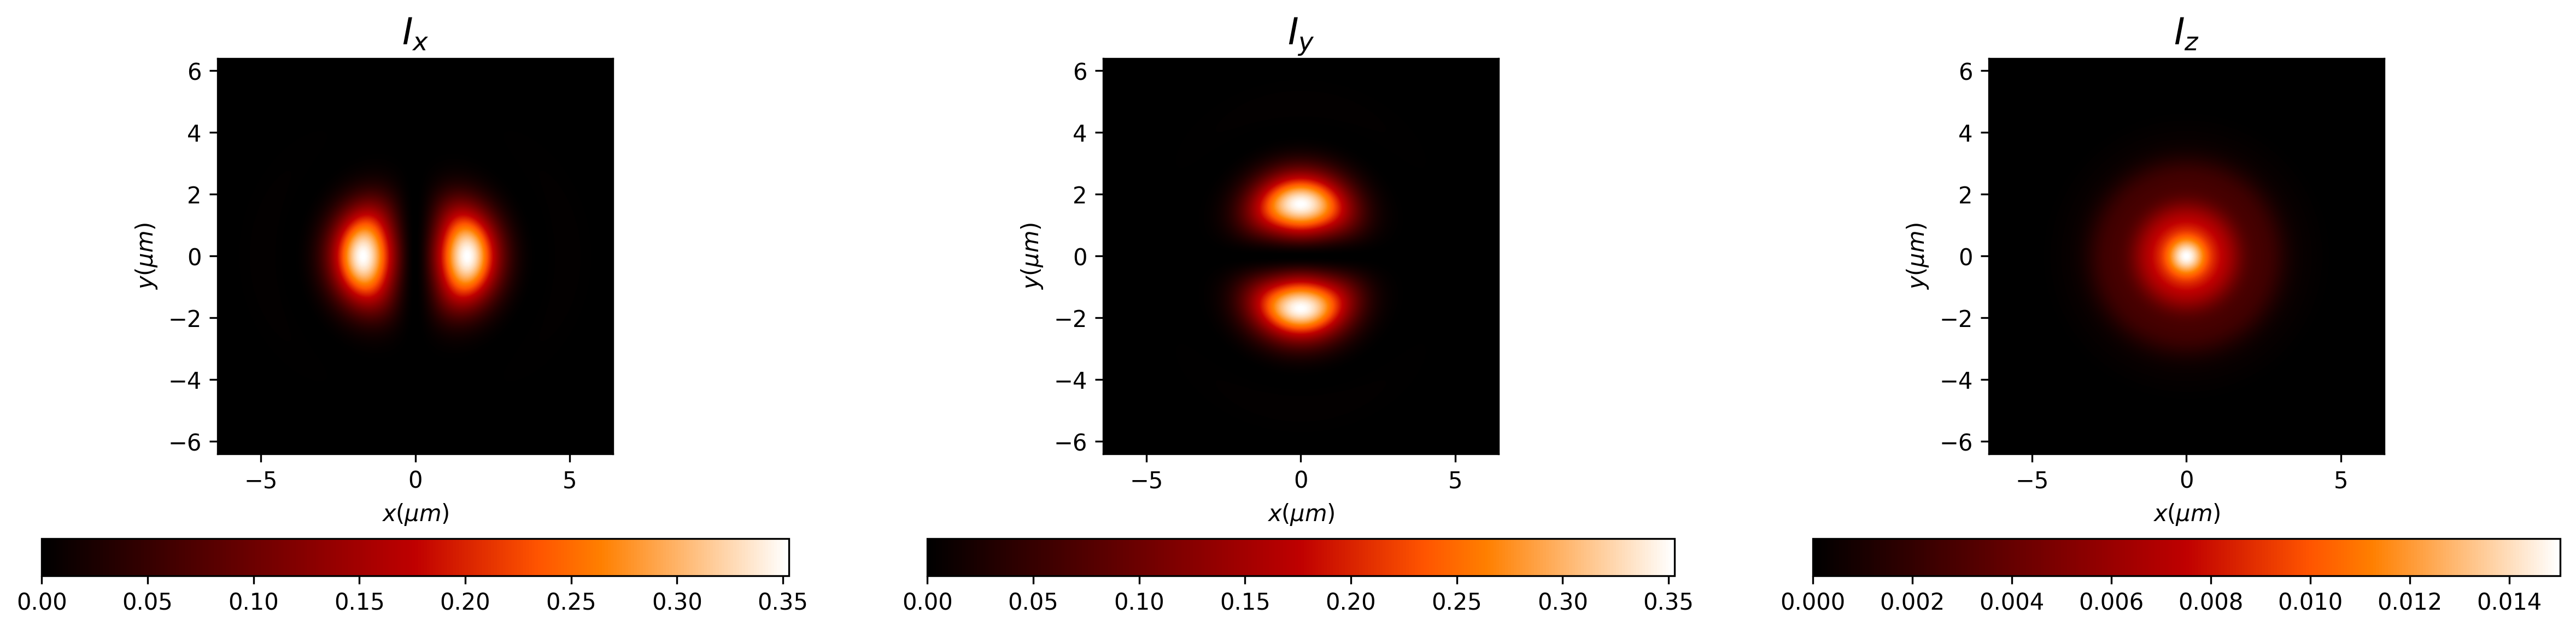

In [54]:
E1=E0.VRS(z=z_obs, n=1, new_field=True)
E1.draw('intensities');

In [55]:
Ex,Ey,_=E1.get('fields', is_matrix=False)
intensity = E1.get('intensity', is_matrix=False)
Ex.u=np.sqrt(intensity.u)

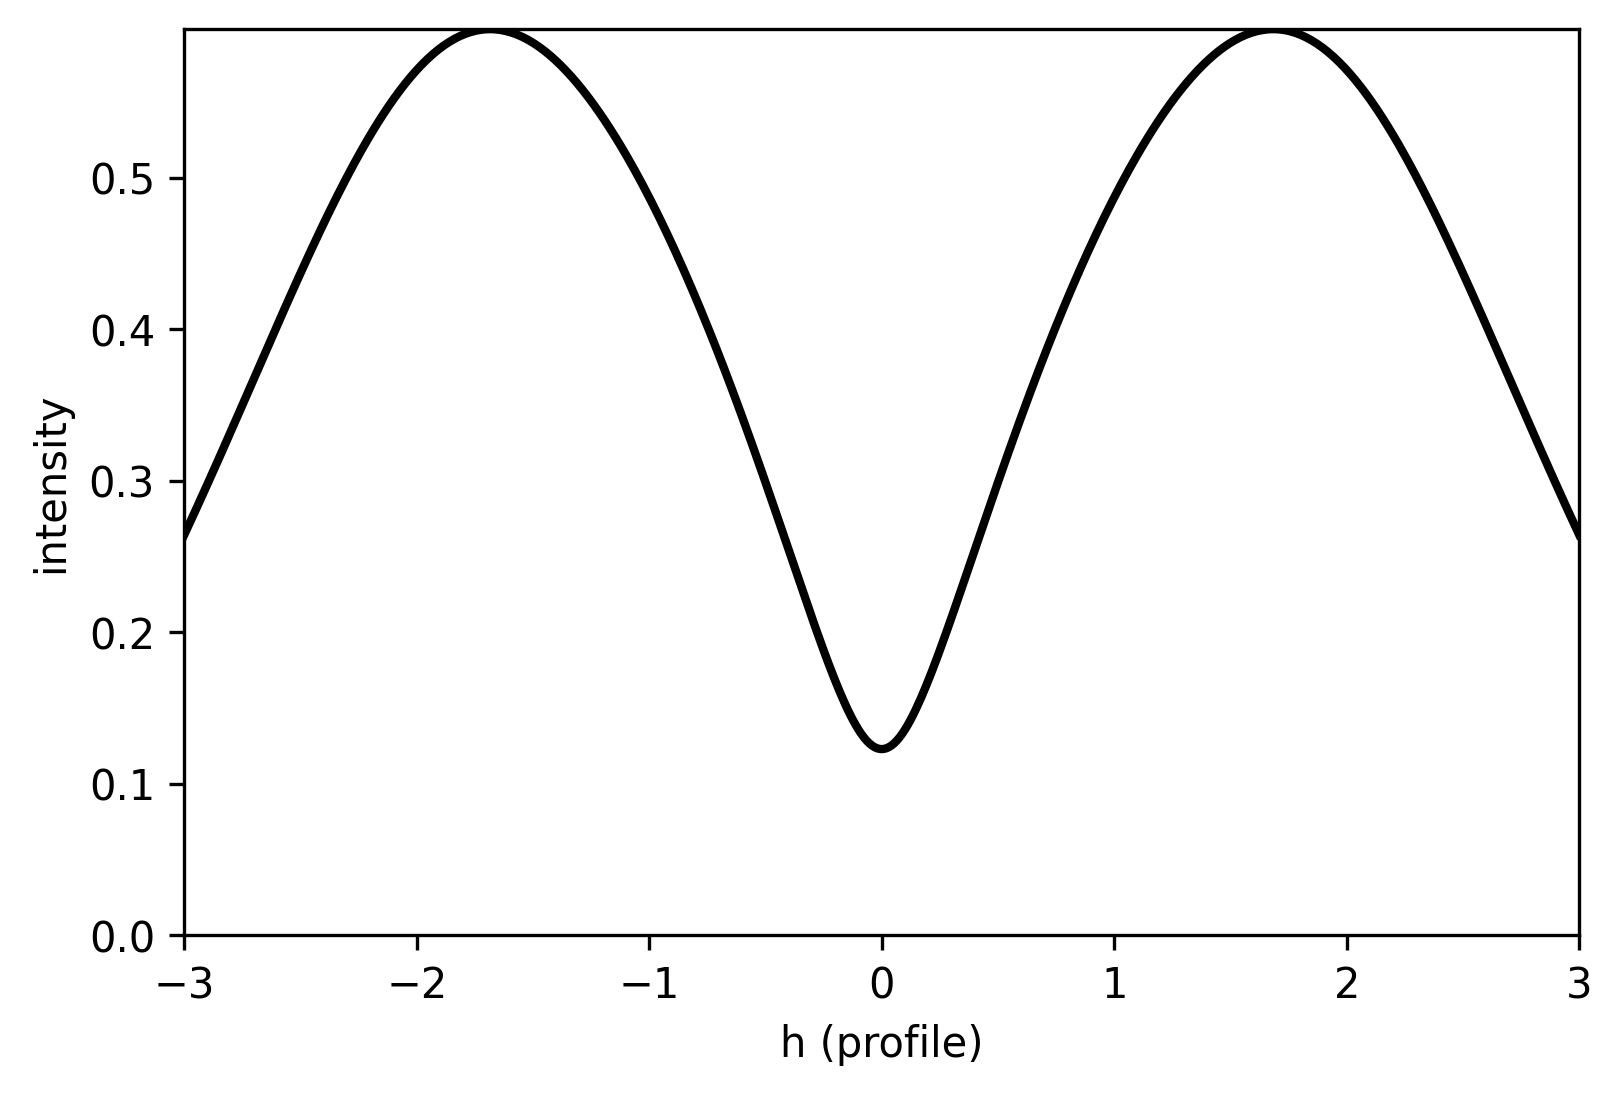

In [56]:
Ex.draw_profile([-3,0],[3,0], order=2); # a trick as draw_profile is not implemented in vector yet.
plt.ylim(ymin=0);

## Focusing with a lens a beam with a high $E_z$ component
In Figures 4 and 5 a planar lens formed by rings is developed in order to obtain a high $E_z$ component. The data of the radii are shown in Table 1.

In [57]:
size=30*um
x0=np.linspace(-size,size,512)
y0=np.linspace(-size,size,512)


In [58]:
wavelength=.6328*um
z_obs=10.32*um

In [59]:
inner_radius=np.array([0.15, 1.3, 2.45, 3.3, 4.25, 5.35, 6.2, 7, 8.35, 9.65, 10.55, 11.9, 13.2, 14.15, 15.25, 
                       16.2, 17.6, 19.05, 19.8, 21.15, 22, 23.05, 24, 24.95, 26, 26.8, 27.55, 28.25, 29.05])

outer_radius=np.array([0.5, 1.95, 3.1, 3.95, 4.9, 6, 6.85, 7.65, 9, 10.3, 11.2, 12.55, 13.85, 14.8, 15.9, 
                      16.85, 18.25, 19.7, 20.45, 21.8, 22.65, 23.7, 24.65, 25.6, 26.65, 27.45, 28.2, 28.9, 29.7])



In [71]:
u0=Scalar_source_XY(x0,y0,wavelength)
u0.plane_wave(A=1)

t0=Scalar_mask_XY(x0,y0,wavelength)
t0.rings(r0=(0,0), inner_radius=inner_radius, outer_radius=outer_radius, mask=True)

t1=u0*t0

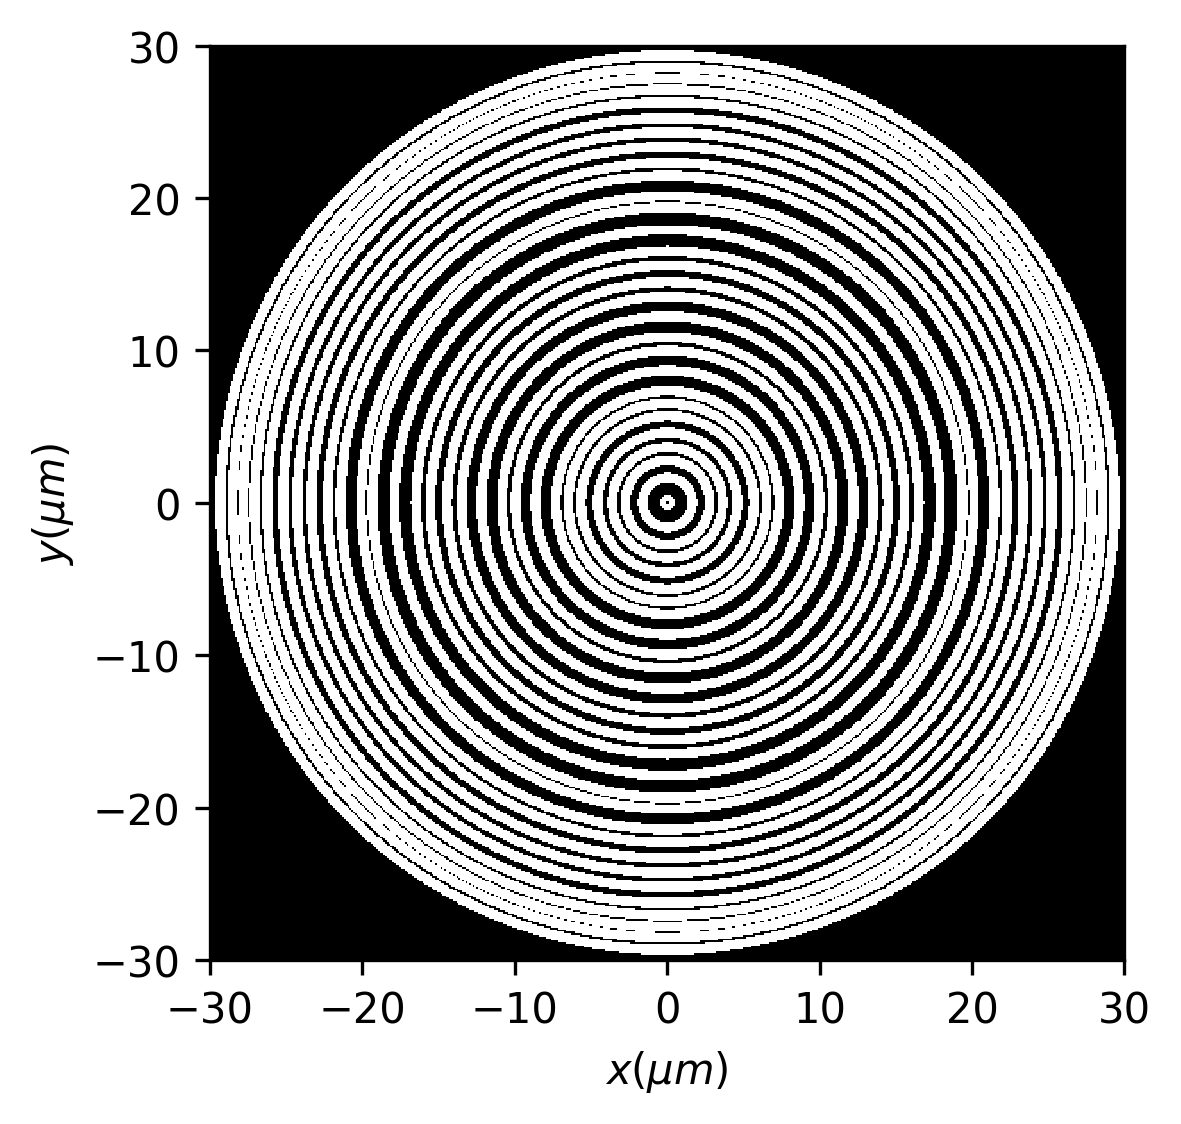

In [72]:
t0.draw();

In [73]:
E0 = Vector_source_XY(x0,y0,wavelength)
E0.radial_wave(u=t1,r0=(0,0))

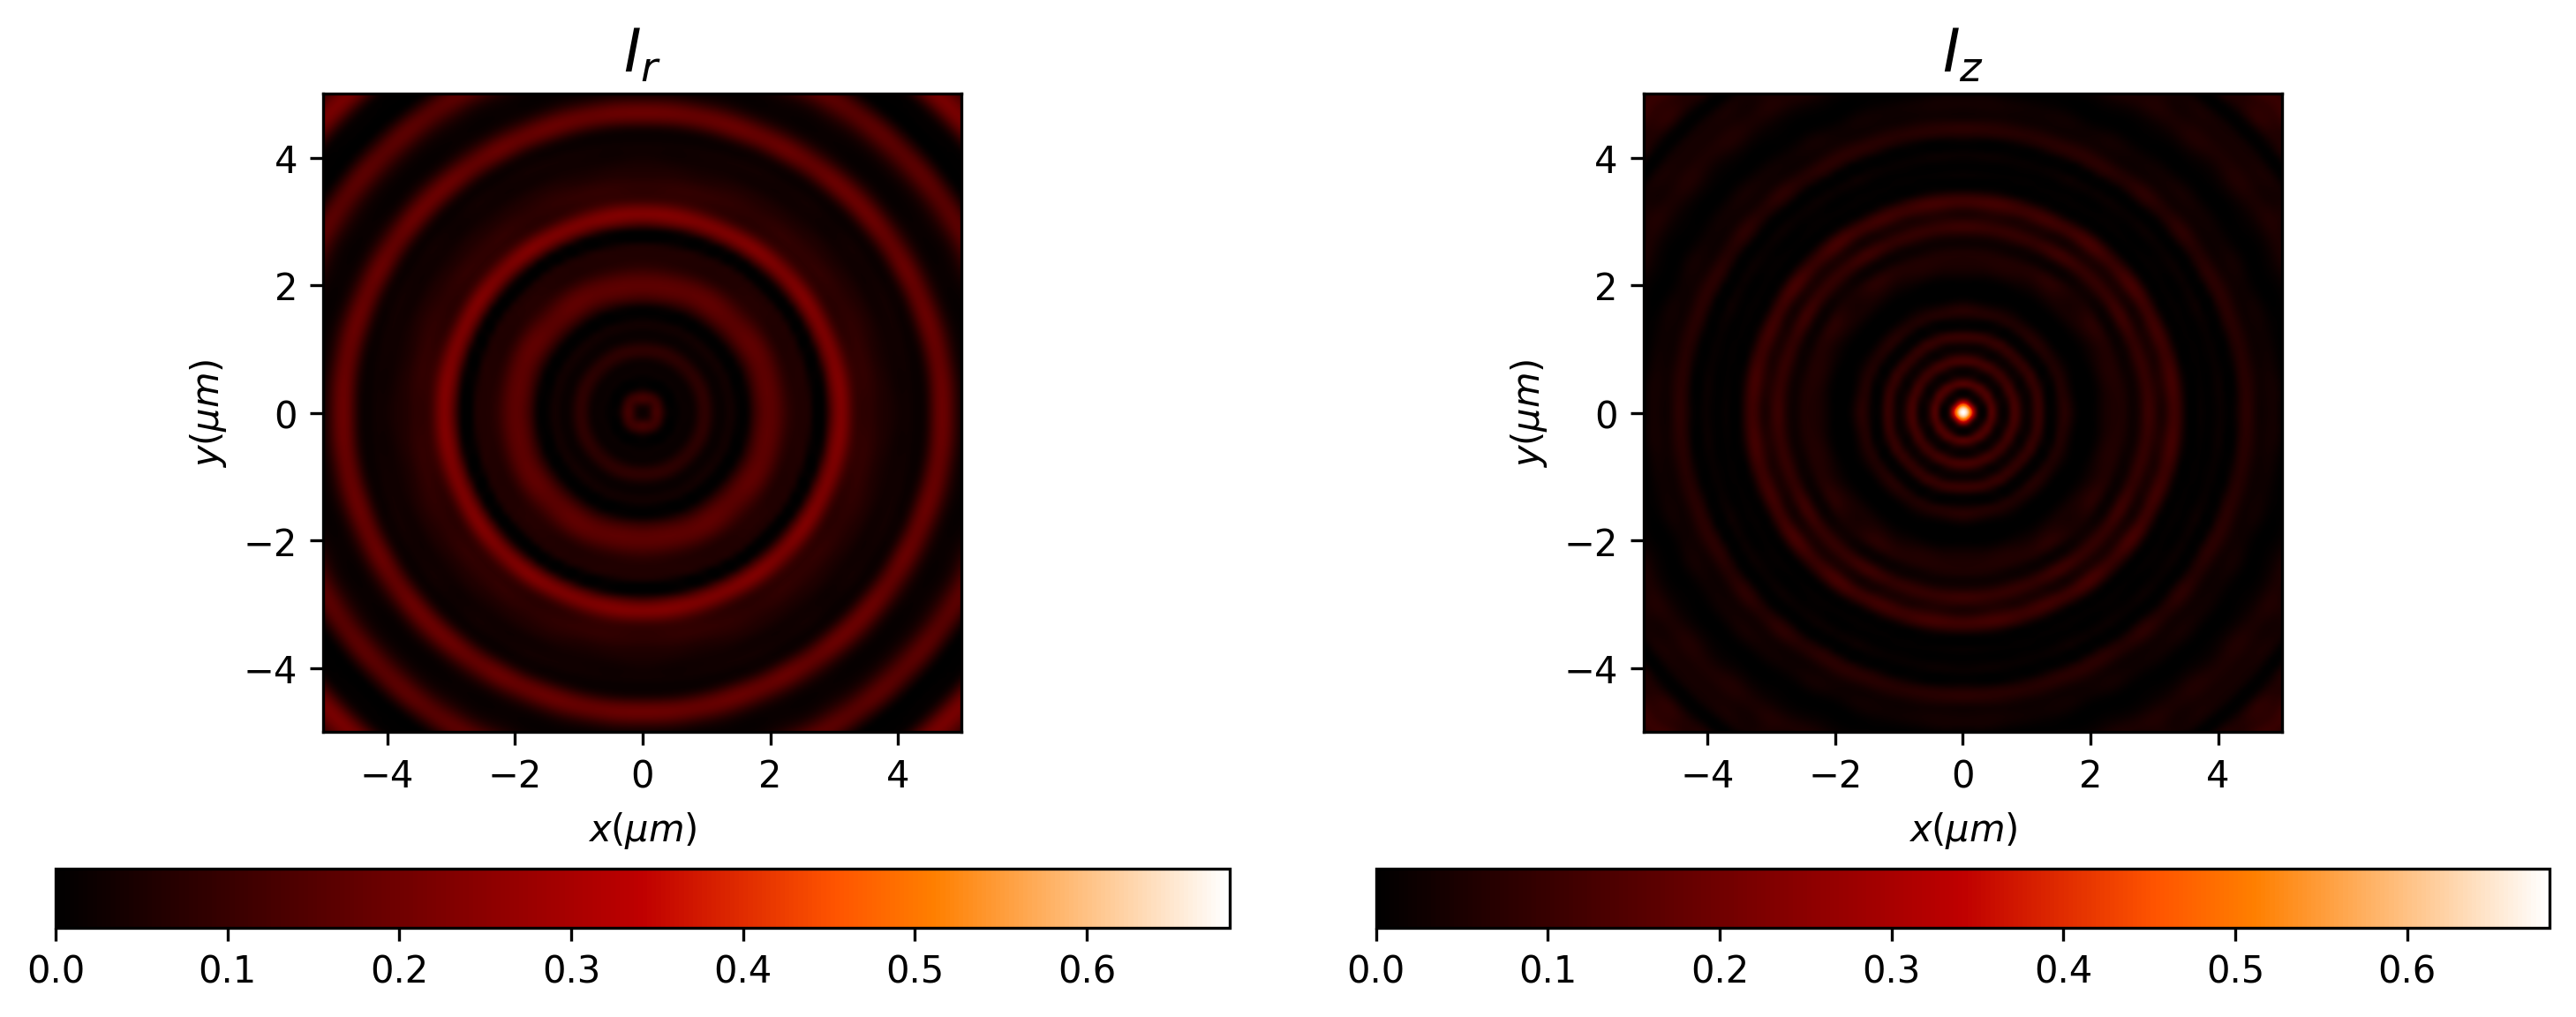

In [77]:
E1=E0.VRS(z=z_obs, n=1, new_field=True)
E1.cut_resample([-5,5],[-5,5],num_points=[512,512])
E1.draw('intensities_rz', logarithm=1e-1);

In [64]:
Ex, Ey, Ez = E1.get('fields', is_matrix=False)

Iz=np.abs(Ez.u)**2
Ir=np.abs(Ex.u)**2+np.abs(Ey.u)**2

I_total=Iz+Ir

Ex.u=np.sqrt(Ir)
Ey.u=np.sqrt(Iz)

z,I_r,_,_=Ex.profile([-3,0],[3,0], order=2);
z,I_z,_,_=Ey.profile([-3,0],[3,0], order=2);

I_total=I_r+I_z

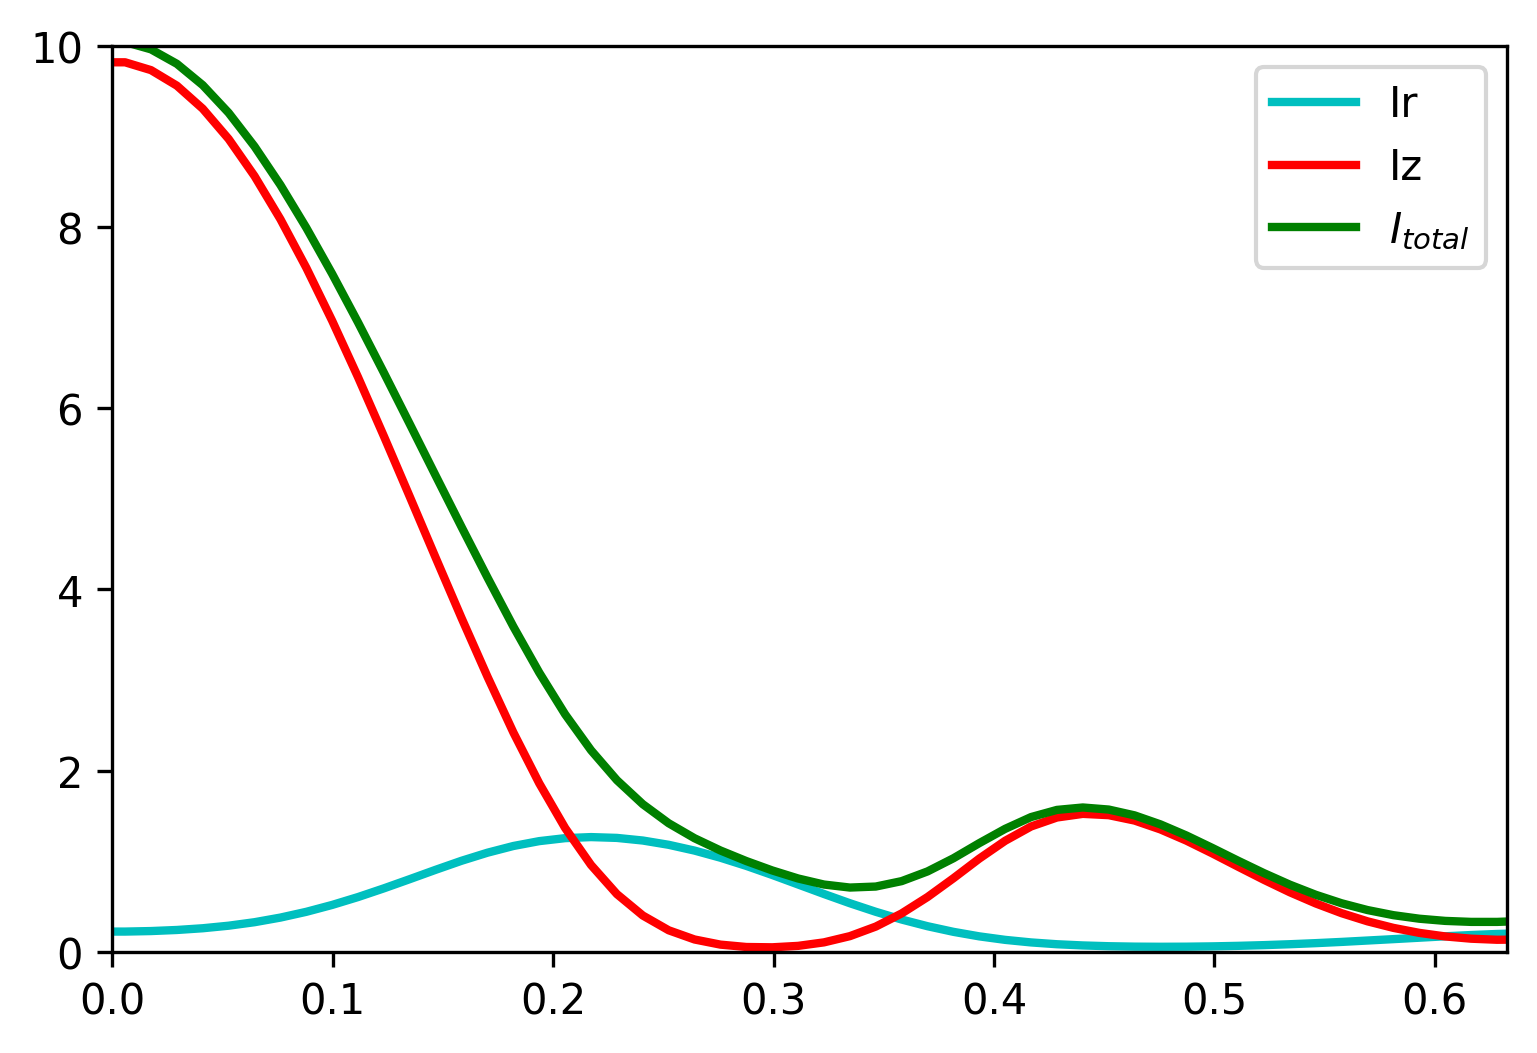

In [65]:
plt.figure()
plt.plot(z, I_r, 'c', lw=2, label='Ir')
plt.plot(z, I_z, 'r', lw=2, label='Iz')
plt.plot(z, I_total, 'g', lw=2, label='$I_{total}$')
plt.legend()

plt.xlim(0,wavelength)
plt.ylim(ymin=0, ymax=10);

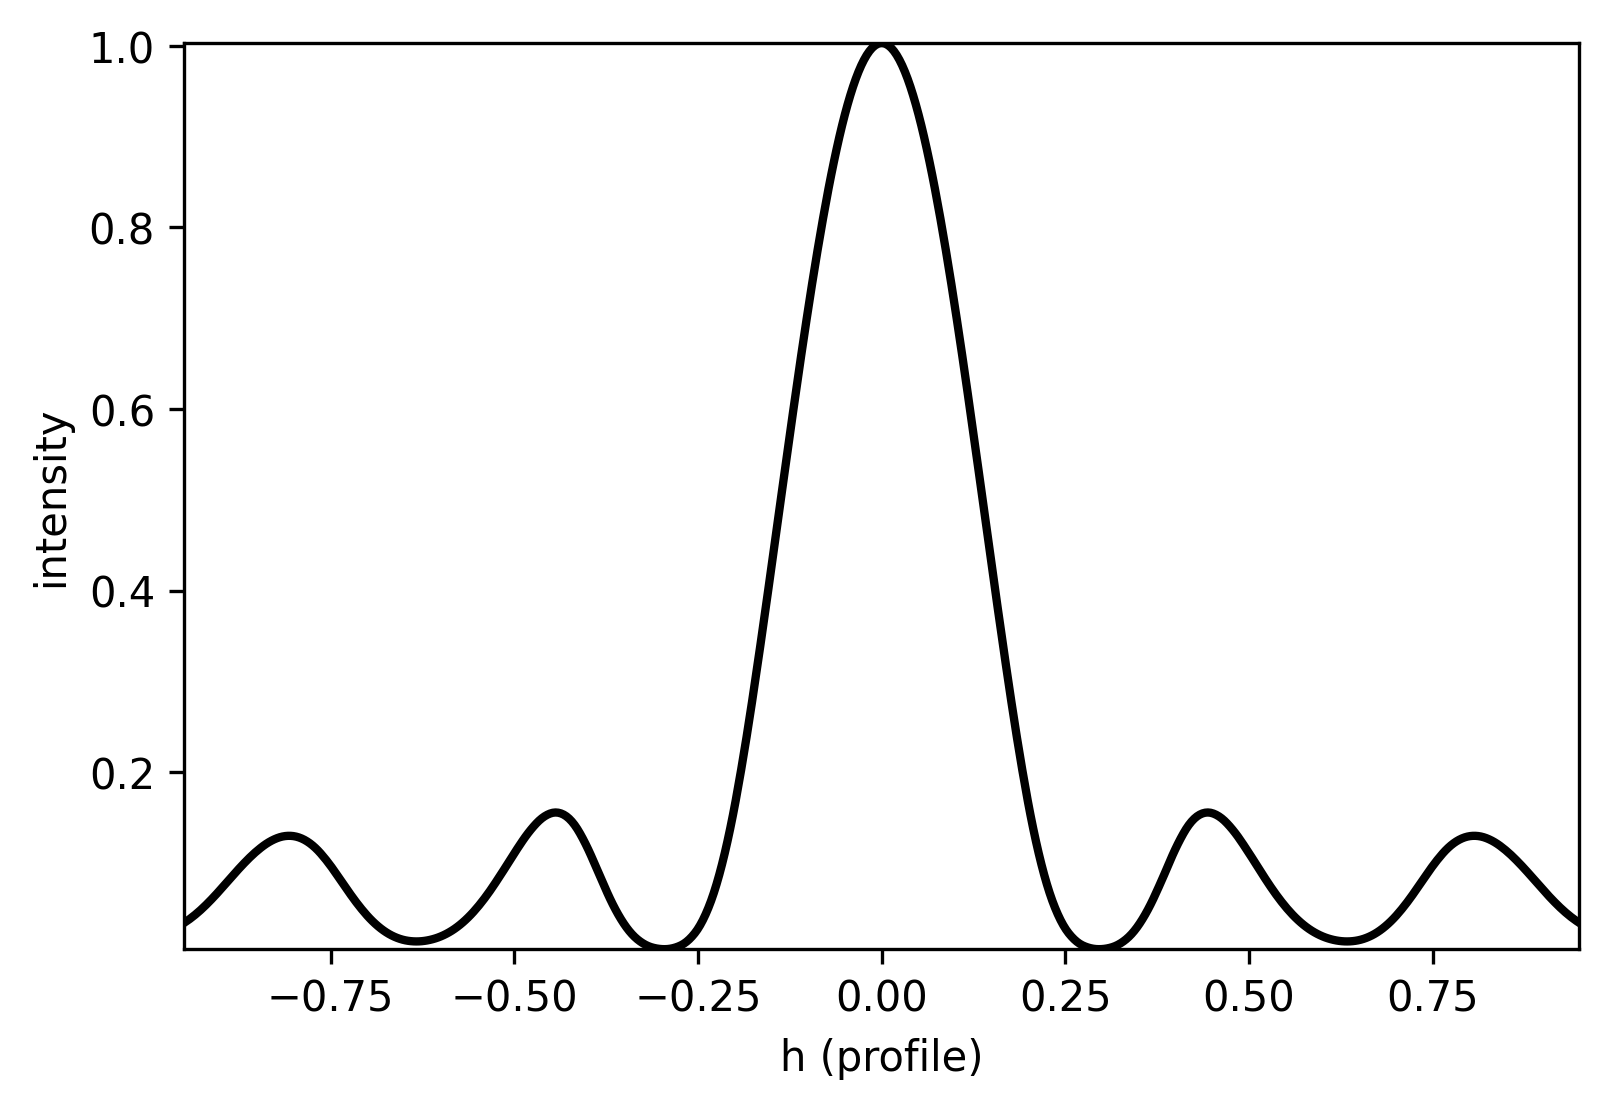

In [66]:
Ey.u=Ey.u/Ey.u.max()
Ey.draw_profile([-1.5*wavelength,0],[1.5*wavelength,0],order=2);

width = 0.4196577637358829 lambda


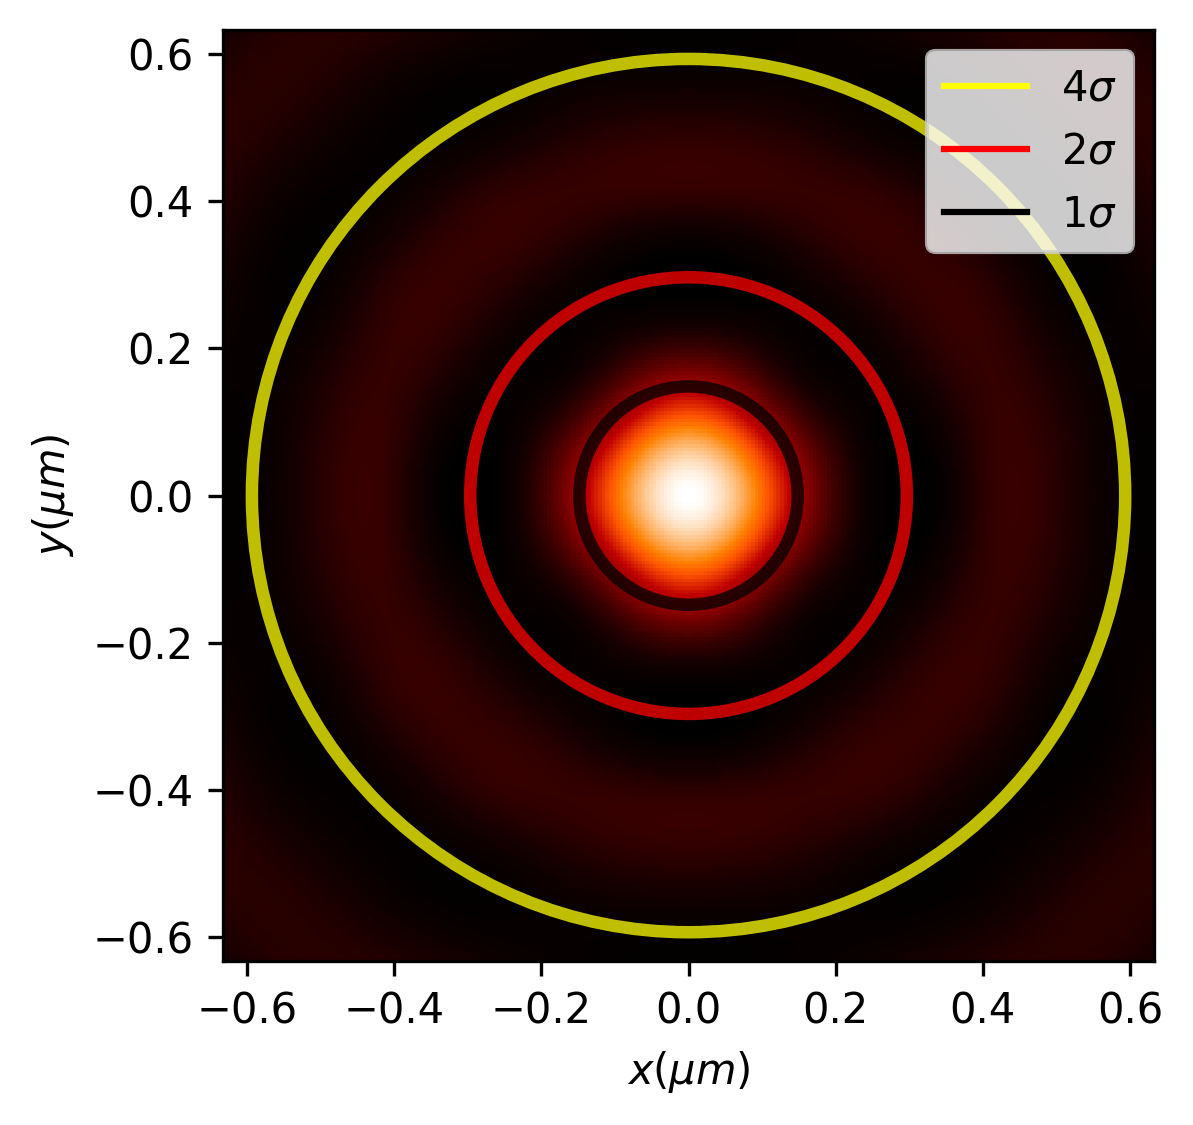

In [67]:
Ey.cut_resample([-wavelength, wavelength], [-wavelength, wavelength],
                num_points=[256, 256])

width, _, _, _ = Ey.beam_width_4s()
print("width = {} lambda".format(width/(2*np.sqrt(2))))
